In [36]:
import os, re
import pandas as pd
import datetime
import nltk
import numpy as np
import gensim
from stop_words import get_stop_words
from nltk.tokenize import PunktSentenceTokenizer
from gensim.models import CoherenceModel
from gensim.utils import simple_preprocess
from gensim.models import TfidfModel
#from wordcloud import WordCloud
from gensim import corpora, models, similarities 
from gensim.parsing.preprocessing import remove_stopwords
import spacy
import itertools
import warnings
warnings.filterwarnings("ignore")
from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer("english")
from datetime import datetime
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams["font.family"] = "Times New Roman"
%matplotlib inline
matplotlib.use('agg')
import itertools
import pickle
from wordcloud import WordCloud
import pyLDAvis
import pyLDAvis.gensim 
pyLDAvis.enable_notebook()

In [237]:
stops = nltk.corpus.stopwords.words('english')+['can','will','also','Sapiens','sapien','sapiens','Majesco','majesco','allianz','Accenture', 'Duck', 'Creek'
                                               'accentur','duck','creek']

In [238]:
#stops = get_stop_words('en')
#stops = stops +['"s',"'s",'s','can','will','also']

In [239]:
#pt = nltk.stem.PorterStemmer()

In [240]:
nlp = spacy.load('en')#, disable=['parser', 'ner'])

In [241]:
#spacy.load('en')

In [242]:
rootDir = '../insunews/'
d = {}
wh = []
for dirName, subdirList, fileList in os.walk(rootDir) :
    print('Found directory: %s' % dirName)
    #print(dirName)
    #print(len(fileList))
    c = 0
    if dirName!='../insunews' and dirName != '../insunews/.ipynb_checkpoints':
        print(dirName)
        loc_name = dirName.replace('../insunews/','')
        d[loc_name] = {}
    for fname in fileList: 
        if fname.endswith(".txt"):  
            
            filepath = os.path.join(dirName, fname)
            
            with open(filepath, 'r', -1, encoding='ISO-8859-1' ) as input_file:
                data = input_file.read()  
                if data != '':
                    c+=1
                    date = re.search(r'\d{1,2}\s\w+\s\d{4}', data)
                    
                    if date != None:
                        date= date.group(0)
                        date_obj = datetime.strptime(date, '%d %B %Y')
                    
                    text = [item for item in data.split('\n\n') if item != '']
                    
                    if not 'Published' in text[2]:
                        whole_text = " ".join(text[2:]) 
                    else:
                        whole_text = " ".join(text[3:]) 
                    #wh.append(whole_text)
            d[loc_name][c] = {'date':date_obj, 'text':whole_text, 'whole':text}
                    
                    #print(c)
                    #print(one_article)
                    
            

Found directory: ../insunews/
../insunews/
Found directory: ../insunews/Middle East and Africa
../insunews/Middle East and Africa
Found directory: ../insunews/North America
../insunews/North America
Found directory: ../insunews/.ipynb_checkpoints
Found directory: ../insunews/Global
../insunews/Global
Found directory: ../insunews/Asia-Pacific
../insunews/Asia-Pacific
Found directory: ../insunews/South and Central America
../insunews/South and Central America
Found directory: ../insunews/Europe
../insunews/Europe


In [243]:
re.search(r'\d{1,2}\s\w+\s\d{4}', data).group(0)

'04 April 2014'

In [244]:
temp = {}
for loc_name, values1 in d.items():
    for number, values2 in values1.items():
        temp.setdefault('locaton', []).append(loc_name)
        temp.setdefault('number', []).append(number)
        for key, value in values2.items():
            #for key, value in date.items():
            temp.setdefault(key, []).append(value)

In [245]:
df = pd.DataFrame(temp)

In [246]:
df['date'] = pd.to_datetime(df['date'])

In [247]:
df['year'] = df['date'].dt.year

In [248]:
wh = list(df['whole'])

In [249]:
text_ls = list(df['text'])

In [250]:
df.to_csv('insurtechnews.csv', index = False)

In [251]:
#df

In [252]:
from gensim.parsing.preprocessing import stem_text, strip_punctuation, strip_punctuation2

In [253]:
from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer("english")

In [254]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))

In [255]:
#tokenized_text = []
#for k, text_raw in enumerate(text_ls):
#    onetext = re.sub('\n', ' ', text_raw, flags= re.IGNORECASE) 
#    print(re.findall(r'\((.*?)\)',text_raw))
#     tokens = list(sent_to_words(nltk.sent_tokenize(onetext)))                
#     tt  = list(itertools.chain(*tokens))
#     stems = [stemmer.stem(t) for t in tt if t not in stops]
#     stems = [word for word in stems if word not in stops]
#     tokenized_text.append(stems)

In [256]:
def tokenized_gensim(total_text):
    tokenized_text = []
    for k, text_raw in enumerate(total_text):
        text = re.sub('\n', ' ', text_raw, flags= re.IGNORECASE) 
        text = re.sub(r'\((?!k\))(?!b\))(.*?)\)',' ', text, flags= re.IGNORECASE)
        try:
            tokens = [word for sent in nltk.sent_tokenize(text) \
              for word in nltk.word_tokenize(sent) if word.lower() not in stops]              
            filtered_tokens = []
            for token in tokens:
                if re.search('[a-zA-Z]', token):
                    token = re.sub(r'[^\w\s]', '', token)
                    filtered_tokens.append(token.lower())
            stems = [stemmer.stem(t) for t in filtered_tokens if t not in stops]
            stems = [word for word in stems if word not in stops]
            tokenized_text.append(stems)
        except Exception as e:
            print(e)
            print(k)
    return tokenized_text

In [257]:
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stops] for doc in texts]

def make_bigrams(bigram_mod, texts):
    return [bigram_mod[doc] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN']):#, 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        #print(sent)
        doc = nlp(" ".join(sent))
        #print(doc)
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [258]:
for t in data_words:
    if 'sapien' in t:
        print(t)

In [259]:
# Tokenized, remove stop words, stemming the whole texts
%time data_words = tokenized_gensim(text_ls)

CPU times: user 14.1 s, sys: 26.4 ms, total: 14.2 s
Wall time: 14.2 s


In [260]:
# Build the bigram and trigram models
%time bigram = gensim.models.Phrases(data_words,\
                                     min_count=5, threshold=100) 
# higher threshold fewer phrases.
#trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
%time bigram_mod = gensim.models.phrases.Phraser(bigram)
#trigram_mod = gensim.models.phrases.Phraser(trigram)

CPU times: user 503 ms, sys: 5.88 ms, total: 508 ms
Wall time: 507 ms
CPU times: user 2.02 s, sys: 0 ns, total: 2.02 s
Wall time: 2.02 s


In [261]:
# Remove Stop Words
%time data_words_nostops = remove_stopwords(data_words)
# Form Bigrams
%time data_words_bigrams = make_bigrams(bigram_mod, data_words_nostops)

CPU times: user 1.36 s, sys: 26.3 ms, total: 1.38 s
Wall time: 1.38 s
CPU times: user 831 ms, sys: 3.57 ms, total: 835 ms
Wall time: 834 ms


In [262]:
# Do lemmatization keeping only noun, adj, vb, adv
%time data_lemmatized = lemmatization(data_words_bigrams,\
                                      allowed_postags=['NOUN'])#, 'ADJ', 'VERB', 'ADV'])

CPU times: user 3min 50s, sys: 5min 24s, total: 9min 14s
Wall time: 1min 18s


In [263]:
#create a Gensim dictionary from the texts
%time dictionary= corpora.Dictionary(data_lemmatized)
#remove extremes (similar to the min/max df step used when creating the tf-idf matrix)
%time dictionary.filter_extremes(no_below=5, no_above=0.7)

CPU times: user 397 ms, sys: 529 ms, total: 926 ms
Wall time: 231 ms
CPU times: user 24.1 ms, sys: 373 µs, total: 24.4 ms
Wall time: 24 ms


In [264]:
#data_lemmatized[100]

In [265]:
#convert the dictionary to a bag of words corpus for reference
%time corpus = [dictionary.doc2bow(text) for text in data_lemmatized]

CPU times: user 101 ms, sys: 4.19 ms, total: 105 ms
Wall time: 105 ms


In [266]:
#corpus

In [282]:
####### LDA model
%time ldamodel = models.LdaModel(corpus, num_topics=10, \
                                   id2word=dictionary, update_every=5,\
                                 chunksize=300, passes=20)

CPU times: user 21.9 s, sys: 52.3 ms, total: 22 s
Wall time: 22 s


In [283]:
import pyLDAvis
import pyLDAvis.gensim 
pyLDAvis.enable_notebook()

In [284]:
# Get the topic related words 
topics_matrix = ldamodel.show_topics(formatted=False, num_words=15, num_topics=10)
topics_matrix = np.array(topics_matrix, dtype=object)
topic_words = topics_matrix[:,1]

allls = []
allls1 = []
for k in range(len(topic_words)):
    wordls = []
    for i, v in topic_words[k]:
        wordls.append(i)
    print(wordls)
    allls.append(wordls)
    allls1.append([wordls])

['risk', 'datum', 'custom', 'model', 'platform', 'compani', 'use', 'claim', 'process', 'busi', 'inform', 'help', 'technolog', 'servic', 'improv']
['risk', 'busi', 'datum', 'claim', 'coverag', 'compani', 'servic', 'product', 'client', 'breach', 'fraud', 'loss', 'custom', 'profession', 'cyber']
['life', 'product', 'model', 'platform', 'benefit', 'suit', 'compani', 'busi', 'financi', 'version', 'annuiti', 'support', 'tower_watson', 'market', 'configur']
['claim', 'compani', 'custom', 'product', 'technolog', 'busi', 'platform', 'servic', 'auto', 'agent', 'system', 'state', 'capabl', 'rate', 'process']
['busi', 'servic', 'compani', 'process', 'technolog', 'custom', 'market', 'platform', 'oper', 'health', 'system', 'financi', 'product', 'plan', 'support']
['agent', 'product', 'carrier', 'process', 'busi', 'platform', 'life', 'technolog', 'custom', 'sale', 'group', 'produc', 'system', 'market', 'rate']
['datum', 'busi', 'report', 'technolog', 'intellig', 'decis', 'compani', 'risk', 'capabl', 

In [285]:
pd.DataFrame(allls)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,risk,datum,custom,model,platform,compani,use,claim,process,busi,inform,help,technolog,servic,improv
1,risk,busi,datum,claim,coverag,compani,servic,product,client,breach,fraud,loss,custom,profession,cyber
2,life,product,model,platform,benefit,suit,compani,busi,financi,version,annuiti,support,tower_watson,market,configur
3,claim,compani,custom,product,technolog,busi,platform,servic,auto,agent,system,state,capabl,rate,process
4,busi,servic,compani,process,technolog,custom,market,platform,oper,health,system,financi,product,plan,support
5,agent,product,carrier,process,busi,platform,life,technolog,custom,sale,group,produc,system,market,rate
6,datum,busi,report,technolog,intellig,decis,compani,risk,capabl,improv,blockchain,client,servic,sight,user
7,claim,group,market,innov,servic,custom,product,technolog,compani,busi,suit,partner,client,sim,digit
8,custom,platform,busi,servic,partner,datum,report,digit,compani,client,product,process,employe,work,team
9,system,busi,guidewir,process,bill,claim,custom,line,product,oper,compani,platform,administr,underwrit,improv


In [296]:
dataprepared = pyLDAvis.gensim.prepare(ldamodel, corpus, dictionary)
pyLDAvis.display(dataprepared)

In [297]:
pyLDAvis.save_html(dataprepared, 'lda.html')

In [293]:
## SAVE 
dictionary.save('dictionary.dict')
corpora.MmCorpus.serialize('corpus.mm', corpus)

In [294]:
## SAVE TEXTS
with open("data_lemmetized.txt", "wb") as fp:   #Pickling
    pickle.dump(data_lemmatized, fp)

In [295]:
### SAVE MODEL
ldamodel.save('ldamodel.model')

In [73]:
## LOAD
dictionary = gensim.corpora.Dictionary.load('dictionary.dict')
corpus = gensim.corpora.MmCorpus('corpus.mm')
ldamodel = gensim.models.ldamodel.LdaModel.load('ldamodel.model')
with open("data_lemmetized.txt",'rb')as f:
    data_lemmatized = pickle.load(f)
    f.close()

In [70]:
dictionary.num_pos

203305

In [71]:
dictionary.num_nnz

130079

# Finding optimal number of topics

In [126]:
def compute_optimal_tp_num(dictionary, corpus, texts, limit, start=2, step=1):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus s
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    parameter_list = list(range(0, limit, 5))
    parameter_list[0] = start
    grid ={}
    cv_dic = {}
    for num_topics in parameter_list:
        print(num_topics)

        model = models.LdaModel(corpus, num_topics=num_topics,\
                                id2word=dictionary, \
                                      update_every=5, chunksize=500,  passes=20)
        model_list.append(model)
        perplex = model.log_perplexity(corpus, total_docs=len(corpus))
        grid[num_topics]=[]
        grid[num_topics].append(perplex)
        coherencemodel = CoherenceModel(model=model, texts=texts,\
                                              dictionary=dictionary, coherence='c_v')
        cv_dic[num_topics]=[]
        cv_dic[num_topics].append(coherencemodel.get_coherence())

    return model_list, cv_dic, grid

In [127]:
%time model_list_rev, coherence_values_rev, grid_rev = compute_optimal_tp_num(dictionary=dictionary,\
                                                                           corpus=corpus,\
                                                       texts=data_lemmatized, start=2, limit=50, step=5)

2
5
10
15
20
25
30
35
40
45
CPU times: user 4min 53s, sys: 2.67 s, total: 4min 56s
Wall time: 5min 5s


In [128]:
coherence_values_rev

{2: [0.3171431954667576],
 5: [0.34531382306766456],
 10: [0.35869924080471266],
 15: [0.3412983282592809],
 20: [0.3373055934563826],
 25: [0.3226057654406883],
 30: [0.3162588245439999],
 35: [0.32118608208359983],
 40: [0.3144855331501897],
 45: [0.3173022108781052]}

In [129]:
grid_rev

{2: [-6.386124094247306],
 5: [-6.3487679606433325],
 10: [-6.3495782173402375],
 15: [-6.386093774542247],
 20: [-6.403902549430168],
 25: [-6.436746616645045],
 30: [-6.471514926214641],
 35: [-6.487999314802211],
 40: [-6.508181907515077],
 45: [-6.533165871175736]}

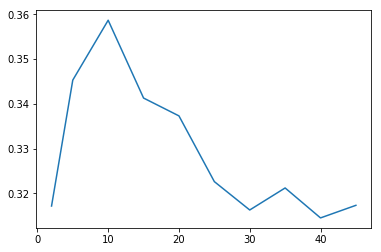

In [130]:
# Show CV
#x = range(start, limit, step)
dfcv = pd.DataFrame(coherence_values_rev)

axcv = plt.figure(figsize=(6,4)).add_subplot(111)
plt.plot(dfcv.iloc[0].transpose())

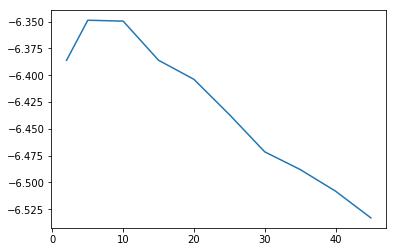

In [131]:
# perplexity
dfp = pd.DataFrame(grid_rev)
plt.plot(dfp.iloc[0].transpose())

# simple_process


In [255]:
# Build the bigram and trigram models
%time bigram2 = gensim.models.Phrases(tokenized_text,\
                                     min_count=5, threshold=100) 
# higher threshold fewer phrases.
#trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
%time bigram_mod2 = gensim.models.phrases.Phraser(bigram2)
#trigram_mod = gensim.models.phrases.Phraser(trigram)

CPU times: user 505 ms, sys: 0 ns, total: 505 ms
Wall time: 504 ms
CPU times: user 1.68 s, sys: 0 ns, total: 1.68 s
Wall time: 1.68 s


In [256]:
# Remove Stop Words
%time data_words_nostops2 = remove_stopwords(tokenized_text)
# Form Bigrams
%time data_words_bigrams2 = make_bigrams(bigram_mod2, data_words_nostops2)

CPU times: user 1.07 s, sys: 6.13 ms, total: 1.08 s
Wall time: 1.07 s
CPU times: user 781 ms, sys: 12.9 ms, total: 794 ms
Wall time: 794 ms


In [257]:
# Do lemmatization keeping only noun, adj, vb, adv
%time data_lemmatized2 = lemmatization(data_words_bigrams2,\
                                      allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

CPU times: user 3min 35s, sys: 5min, total: 8min 35s
Wall time: 1min 4s


In [258]:
#create a Gensim dictionary from the texts
%time dictionary2= corpora.Dictionary(data_lemmatized2)
#remove extremes (similar to the min/max df step used when creating the tf-idf matrix)
%time dictionary2.filter_extremes(no_below=5, no_above=0.7)

CPU times: user 472 ms, sys: 482 ms, total: 953 ms
Wall time: 264 ms
CPU times: user 16.4 ms, sys: 415 µs, total: 16.8 ms
Wall time: 16.4 ms


In [259]:
#convert the dictionary to a bag of words corpus for reference
%time corpus2 = [dictionary2.doc2bow(text2) for text2 in data_lemmatized2]

CPU times: user 173 ms, sys: 0 ns, total: 173 ms
Wall time: 171 ms


In [302]:
####### LDA model
%time ldamodel2 = models.LdaModel(corpus2, num_topics=20, \
                                   id2word=dictionary2, update_every=5,\
                                 chunksize=500, passes=20)

CPU times: user 29.1 s, sys: 0 ns, total: 29.1 s
Wall time: 29.1 s


In [303]:
# Get the topic related words 
topics_matrix2 = ldamodel2.show_topics(formatted=False, num_words=15, num_topics=15)
topics_matrix2 = np.array(topics_matrix2, dtype=object)
topic_words2 = topics_matrix2[:,1]

allls2 = []
allls12 = []
for k2 in range(len(topic_words2)):
    wordls2 = []
    for i2, v2 in topic_words2[k2]:
        wordls2.append(i2)
    print(wordls2)
    allls.append(wordls2)
    allls1.append([wordls2])

['servic', 'softwar', 'custom', 'duck_creek', 'csc', 'new', 'compani', 'suit', 'busi', 'market', 'fineo', 'technolog', 'sapien', 'cloud', 'base']
['process', 'solut', 'datum', 'new', 'underwrit', 'use', 'inform', 'content', 'rate', 'time', 'system', 'applic', 'allow', 'enabl', 'claim']
['product', 'cyber', 'broker', 'coverag', 'new', 'offer', 'breach', 'servic', 'polici', 'protect', 'compani', 'custom', 'datum', 'busi', 'liabil']
['servic', 'custom', 'technolog', 'solut', 'compani', 'industri', 'busi', 'market', 'innov', 'platform', 'partner', 'client', 'product', 'new', 'digit']
['claim', 'solut', 'system', 'softwar', 'process', 'busi', 'servic', 'report', 'compani', 'user', 'administr', 'base', 'capabl', 'new', 'custom']
['risk', 'report', 'datum', 'analyt', 'complianc', 'solut', 'use', 'invest', 'requir', 'help', 'portfolio', 'tool', 'busi', 'inform', 'financi']
['health', 'life', 'benefit', 'care', 'applic', 'mobil', 'plan', 'servic', 'solut', 'symbl', 'exchang', 'employ', 'member'

In [305]:
dataprepared2 = pyLDAvis.gensim.prepare(ldamodel2, corpus2, dictionary2)
pyLDAvis.display(dataprepared2)

# calculate topic distribution

In [58]:
from __future__ import absolute_import
import funcy as fp
import numpy as np
import pandas as pd
from scipy.sparse import issparse
from past.builtins import xrange
#from . import prepare as vis_prepare


def _extract_data(topic_model, corpus, dictionary, doc_topic_dists=None):
    import gensim
    if not gensim.matutils.ismatrix(corpus):
        corpus_csc = gensim.matutils.corpus2csc(corpus, num_terms=len(dictionary))
    else:
        corpus_csc = corpus
        # Need corpus to be a streaming gensim list corpus for len and inference functions below:
        corpus = gensim.matutils.Sparse2Corpus(corpus_csc)

    vocab = list(dictionary.token2id.keys())
     # TODO: add the hyperparam to smooth it out? no beta in online LDA impl.. hmm..
    # for now, I'll just make sure we don't ever get zeros...
    beta = 0.01
    fnames_argsort = np.asarray(list(dictionary.token2id.values()), dtype=np.int_)
    term_freqs = corpus_csc.sum(axis=1).A.ravel()[fnames_argsort]
    term_freqs[term_freqs == 0] = beta
    doc_lengths = corpus_csc.sum(axis=0).A.ravel()

    assert term_freqs.shape[0] == len(dictionary), 'Term frequencies and dictionary have different shape {} != {}'.format(term_freqs.shape[0], len(dictionary))
    assert doc_lengths.shape[0] == len(corpus), 'Document lengths and corpus have different sizes {} != {}'.format(doc_lengths.shape[0], len(corpus))

    if hasattr(topic_model, 'lda_alpha'):
        num_topics = len(topic_model.lda_alpha)
    else:
        num_topics = topic_model.num_topics

    if doc_topic_dists is None:
        # If its an HDP model.
        if hasattr(topic_model, 'lda_beta'):
            gamma = topic_model.inference(corpus)
        else:
            gamma, _ = topic_model.inference(corpus)
        doc_topic_dists = gamma / gamma.sum(axis=1)[:, None]
    else:
        if isinstance(doc_topic_dists, list):
            doc_topic_dists = gensim.matutils.corpus2dense(doc_topic_dists, num_topics).T
        elif issparse(doc_topic_dists):
            doc_topic_dists = doc_topic_dists.T.todense()
        doc_topic_dists = doc_topic_dists / doc_topic_dists.sum(axis=1)

    assert doc_topic_dists.shape[1] == num_topics, 'Document topics and number of topics do not match {} != {}'.format(doc_topic_dists.shape[1], num_topics)

    # get the topic-term distribution straight from gensim without
    # iterating over tuples
    if hasattr(topic_model, 'lda_beta'):
        topic = topic_model.lda_beta
    else:
        topic = topic_model.state.get_lambda()
    topic = topic / topic.sum(axis=1)[:, None]
    topic_term_dists = topic[:, fnames_argsort]

    assert topic_term_dists.shape[0] == doc_topic_dists.shape[1]

    d =  {'topic_term_dists': topic_term_dists, 'doc_topic_dists': doc_topic_dists,
           'doc_lengths': doc_lengths, 'vocab': vocab, 'term_frequency': term_freqs}
    return d

In [59]:
do = _extract_data(ldamodel, corpus, dictionary)

In [60]:
dtt = pd.DataFrame(do['doc_topic_dists']).reset_index()

In [61]:
dtt['year'] = df['year']

In [62]:
dttm = pd.melt(dtt, id_vars=['index','year'], value_vars=[0,1,2,3,4,5,6,7,8,9])

In [63]:
dttm.rename(columns={'index':'doc_index','variable':'topic_no','value':'topic_weight'}, inplace = True)

In [64]:
dtm1 = dttm.pivot(index='doc_index', columns='topic_no', values='topic_weight').fillna(0)

In [65]:
dtm2 = dtm1.div(dtm1.sum(axis=1), axis=0)

# Shift back to a long dataframe
dt_norm2 = dtm2.stack().reset_index()
dt_norm2.columns = ['doc_index', 'topic_id', 'norm_topic_weight']

In [66]:
len(text_ls)

1331

In [67]:
dt_norm21 = dt_norm2.merge(dttm[['year','doc_index']] ,on = 'doc_index').drop_duplicates()

In [34]:
#text_ls[674]

In [35]:
#wh[235]

In [70]:
max_df = dt_norm21[dt_norm21.groupby(['doc_index'])['norm_topic_weight'].transform(max) == dt_norm21['norm_topic_weight']]

In [71]:
topic1 = max_df[max_df['topic_id'] == 0]
topic1.sort_values('norm_topic_weight', ascending=False)

,doc_index,topic_id,norm_topic_weight,year
67400,674,0,0.995566,1970
1200,12,0,0.993381,1970
14200,142,0,0.991087,1970
46200,462,0,0.989154,1970
67100,671,0,0.988308,1970
121700,1217,0,0.987669,1970
108700,1087,0,0.986953,1970
79800,798,0,0.986953,1970
123800,1238,0,0.986762,1970
131800,1318,0,0.986565,1970


In [72]:
max_counts = max_df[['doc_index', 'year', 'topic_id']].groupby(['year', 'topic_id']).agg({'doc_index' : 'count'}).reset_index()
max_counts.columns = ['year', 'topic_id', 'max_count']

In [73]:
# Count the number of individual documents per year
total_docs = max_df[['year', 'doc_index']].groupby('year').agg({'doc_index' : 'count'}).reset_index()
total_docs.columns = ['year', 'total_docs']

In [74]:
total_docs

,year,total_docs
0,1970,1331


In [75]:
# Combine the two dataframes
max_counts = max_counts.merge(total_docs, on='year', how='left')

In [76]:
max_counts['prevalence'] = max_counts['max_count']/max_counts['total_docs']


In [77]:
max_counts

,year,topic_id,max_count,total_docs,prevalence
0,1970,0,132,1331,0.099174
1,1970,1,148,1331,0.111195
2,1970,2,300,1331,0.225394
3,1970,3,118,1331,0.088655
4,1970,4,149,1331,0.111946
5,1970,5,77,1331,0.057851
6,1970,6,128,1331,0.096168
7,1970,7,46,1331,0.034560
8,1970,8,175,1331,0.131480
9,1970,9,58,1331,0.043576


# Graph

In [121]:
NUMDOCS = 60 # number of subreddits OR number of BBC documents per category
NUMTOPICS = 10
def toVector(l):
    ''' inserts 0s for unrepresented topics in a document
        input: return value from ldamodel.get_document_topics(corpus[i])
        output: document topics with 0s for unrepresented topics'''
    ret = []
    t = 0
    for i in range(NUMTOPICS):
        if t == len(l):
            ret += [0]
        elif l[t][0] == i + 1:
            ret += [l[t][1]]
            t = t + 1
        else:
            ret += [0]
    return ret

In [123]:
#text_ls#

In [75]:
EPS = 0.001
numDocs = len(text_ls)
# note: this can take a long time on large corpora
similarity = [[0 for x in range(numDocs)] for y in range(numDocs)]

for i in range(numDocs):
    itops = toVector(ldamodel.get_document_topics(corpus[i]))
    for j in range(numDocs)[i:]:
        jtops = toVector(ldamodel.get_document_topics(corpus[j]))
        sim = 1.0 - gensim.matutils.hellinger(itops, jtops)
        sim = min(sim + EPS, 1.0)
        
        similarity[i][j] = sim


In [85]:
type(similarity)

list

In [88]:
import pickle

In [90]:
with open('similarity','wb') as f:
    pickle.dump(similarity,f)

In [92]:
d = pickle.load(open('similarity', 'rb'))

In [96]:
len(d)

1330

In [298]:
# Wordclouds
wc = WordCloud(
    background_color="white",
    max_words=200,
    width=800,
    height=600,
    stopwords= stops#stopwords.words('english')
)
#WordCloud().fit_words(dict(lda.show_topic(t, 200)))
for t in range(ldamodel.num_topics):
    name = "Topic #" + str(t+1)
    plt.figure().subplots_adjust(bottom=0, top=1, left=0, right=1)
    plt.imshow(wc.fit_words(dict(ldamodel.show_topic(t, 200))))
    plt.axis("off")
    #plt.title("Topic #" + str(t))
    
    plt.savefig(str(name)+'.png', dpi=300,facecolor='w',bbox_inches="tight", pad_inches = 0)
    plt.close()
    #plt.close()
    #plt.show()